In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from datetime import timedelta
from scipy.interpolate import griddata
import cartopy.crs as ccrs
import io
from matplotlib.animation import FuncAnimation
from matplotlib.animation import ArtistAnimation
from PIL import Image
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import ImageGrid
import cartopy.feature as cfeature
from scipy.stats import binned_statistic_2d as histo2D

c:\Users\virtanem\Anaconda3\envs\gradu\Lib\site-packages\pyproj\__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
path = 'data/filtered20230118.csv'

dtypes = {'gps_site': str,
 'sat_id': str,
 'gdlatr': float,
 'gdlonr': float,
 'los_tec': float,
 'tec': float,
 'azm': float,
 'elm': float,
 'gdlat': float,
 'glon': float,
 'gnss_type': str,
 'slant_f': float,
 'vtec': float,
 'pair_id': str,
 'curve_id': int,
 'filtered': float,
 'blrmvd': float}

raw = pd.read_csv(path, dtype=dtypes)

raw['datetime'] = pd.to_datetime(raw['datetime'])

In [3]:
MIN_ELEVATION = 20

def trim_curve(group):
    group = group.sort_values('datetime')
    start_time = group['datetime'].iloc[0] + timedelta(minutes=15)
    end_time = group['datetime'].iloc[-1] - timedelta(minutes=15)
    return group[(group['datetime'] >= start_time) & (group['datetime'] <= end_time)]

data = raw.groupby(['pair_id', 'curve_id']).apply(trim_curve).reset_index(drop=True)
data = data.loc[data['elm'] > MIN_ELEVATION]
data = data[(data['datetime'].dt.hour >= 6) & (data['datetime'].dt.hour < 18)]

C:\Users\virtanem\AppData\Local\Temp\ipykernel_19264\460248443.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = raw.groupby(['pair_id', 'curve_id']).apply(trim_curve).reset_index(drop=True)


In [4]:
df = data.groupby('datetime').filter(lambda x: len(x) >= 1000)
print(len(df['datetime'].unique()), len(data['datetime'].unique()))
sites = df['gps_site'].unique().tolist()
frames = sorted(df['datetime'].unique())
allsites = {}
allsites[f'{frames[0]}'] = sites

1120 1440


In [5]:
df0 = data.groupby('datetime').filter(lambda x: len(x) <= 1000)
print(len(df0['datetime'].unique()), len(data['datetime'].unique()))
blips = sorted(df0['datetime'].unique())
blip_sites = df0['gps_site'].unique().tolist()
allblip_sites = {}
allblip_sites[f'{frames[0]}'] = blip_sites

320 1440


Always Used Stations: ["b'6ove'", "b'0bue'", "b'0kiv'", "b'kir8'", "b'0svt'", "b'vaas'", "b'0ove'", "b'0skh'", "b'0skc'", "b'6ume'", "b'0gum'", "b'0bra'", "b'torn'", "b'2arh'", "b'svtl'", "b'0kor'", "b'0med'", "b'2hus'", "b'0jav'", "b'pyha'", "b'0ers'", "b'joen'", "b'olk2'", "b'hett'", "b'pulk'", "b'0pis'", "b'0ovt'", "b'savu'", "b'1bos'", "b'0ans'", "b'0nat'", "b'0ske'", "b'rom2'", "b'0svp'", "b'0nos'", "b'0sak'", "b'1rof'", "b'0sav'", "b'0faf'", "b'0veb'", "b'mets'", "b'kuu2'", "b'0vin'", "b'kiv2'", "b'vir2'", "b'0juo'", "b'0kir'", "b'0tav'", "b'oriv'", "b'hons'", "b'0vri'", "b'tuo2'", "b'0gst'", "b'0flr'", "b'0laj'", "b'0lak'", "b'ove6'", "b'0gun'", "b'0lul'", "b'8kir'", "b'0hlm'", "b'kir0'", "b'0dun'", "b'ske0'", "b'0ams'", "b'0jor'", "b'kilp'", "b'oul2'", "b'vars'", "b'met3'", "b'0lva'", "b'fins'", "b'0gva'", "b'0kie'", "b'0ume'", "b'ume6'", "b'kev2'", "b'0bur'", "b'0mse'", "b'mik3'", "b'soda'", "b'0rat'", "b'0jok'", "b'0kic'", "b'0blg'", "b'0mrj'", "b'0bju'", "b'0beb'", "b'0arv'", "b'0glo'", "b'1alb'", "b'0bas'", "b'0vid'", "b'metg'", "b'0ull'", "b'0nik'", "b'joe2'", "b'0mlm'", "b'1lat'", "b'vaa2'", "b'0ros'", "b'0teg'", "b'0hos'", "b'sod3'", "b'0hap'", "b'0vit'", "b'0rau'", "b'0sop'", "b'0saa'", "b'8ske'", "b'0dav'", "b'0byg'", "b'0pju'", "b'0hrn'", "b'0kab'", "b'0nyb'"]


Never Used Stations: ["b'tarv'", "b'sur4'", "b'njoe'", "b'pyrk'", "b'ajoe'", "b'kusa'", "b'mus2'", "b'verg'", "b'rall'", "b'kosi'", "b'toil'"]


In [7]:
paths = ['data/filtered20231202.csv',
         'data/filtered20230319.csv',
         'data/filtered20230321.csv',
         'data/filtered20230322.csv']
for path in paths:

    dtypes = {'gps_site': str,
    'sat_id': str,
    'gdlatr': float,
    'gdlonr': float,
    'los_tec': float,
    'tec': float,
    'azm': float,
    'elm': float,
    'gdlat': float,
    'glon': float,
    'gnss_type': str,
    'slant_f': float,
    'vtec': float,
    'pair_id': str,
    'curve_id': int,
    'filtered': float,
    'blrmvd': float}

    raw = pd.read_csv(path, dtype=dtypes)

    raw['datetime'] = pd.to_datetime(raw['datetime'])

    MIN_ELEVATION = 20

    def trim_curve(group):
        group = group.sort_values('datetime')
        start_time = group['datetime'].iloc[0] + timedelta(minutes=15)
        end_time = group['datetime'].iloc[-1] - timedelta(minutes=15)
        return group[(group['datetime'] >= start_time) & (group['datetime'] <= end_time)]

    data = raw.groupby(['pair_id', 'curve_id']).apply(trim_curve).reset_index(drop=True)
    data = data.loc[data['elm'] > MIN_ELEVATION]
    data = data[(data['datetime'].dt.hour >= 6) & (data['datetime'].dt.hour < 18)]

    df = data.groupby('datetime').filter(lambda x: len(x) >= 1000)
    frames = sorted(df['datetime'].unique())
    print(len(df['datetime'].unique()), len(data['datetime'].unique()))
    sites=df['gps_site'].unique().tolist()
    allsites[f'{frames[0]}'] = sites

    df0 = data.groupby('datetime').filter(lambda x: len(x) <= 1000)
    print(len(df0['datetime'].unique()), len(data['datetime'].unique()))
    blips = sorted(df0['datetime'].unique())
    blip_sites=df0['gps_site'].unique().tolist()
    allblip_sites[f'{frames[0]}'] = blip_sites

C:\Users\virtanem\AppData\Local\Temp\ipykernel_19264\387514568.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = raw.groupby(['pair_id', 'curve_id']).apply(trim_curve).reset_index(drop=True)


1120 1440
320 1440


C:\Users\virtanem\AppData\Local\Temp\ipykernel_19264\387514568.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = raw.groupby(['pair_id', 'curve_id']).apply(trim_curve).reset_index(drop=True)


1120 1440
320 1440


C:\Users\virtanem\AppData\Local\Temp\ipykernel_19264\387514568.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = raw.groupby(['pair_id', 'curve_id']).apply(trim_curve).reset_index(drop=True)


1120 1440
320 1440


C:\Users\virtanem\AppData\Local\Temp\ipykernel_19264\387514568.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = raw.groupby(['pair_id', 'curve_id']).apply(trim_curve).reset_index(drop=True)


1120 1440
320 1440


In [ ]:
def create_fig_s(fig, ax, datetime, df, RES=0.5):
    df1 = df.loc[df['datetime'] == datetime]

    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # ax.set_xticks(np.arange(19, 32, 1))
    # ax.set_yticks(np.arange(59, 72, 1))
  
    plt.scatter(df1['glon'], df1['gdlat'],c= df1['blrmvd'], cmap='plasma', vmin=-2, vmax=2)
    
    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.155, 0.05, 0.67])

    plt.colorbar(cax=cax, orientation='vertical', label='VTEC',
                        extendrect = True, ticks=np.arange(-2,2.5,0.5), 
                        boundaries = np.arange(-2,2.5,0.5), extend='both'
                        )

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Baseline removed VTEC at {datetime}')

    ax.set_xlim(-10, 60)
    ax.set_ylim(40, 80)

def show_fig(datetime, df, RES=0.5):
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    create_fig_s(fig, ax, datetime, df, RES)
    plt.show(fig)

# frames = sorted(df['datetime'].unique())
# show_fig(frames[11], df, RES=0.5)

In [ ]:
def update(frame):
    df1 = df.loc[df['datetime'] == frame]
    ax.clear()

    ax.set_xlim(19, 31)
    ax.set_ylim(59,71)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.set_xticks(np.arange(19, 32, 1))
    ax.set_yticks(np.arange(59, 72, 1))
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Baseline removed VTEC at {frame}')
    plot = ax.scatter(df1['glon'], df1['gdlat'],c= df1['blrmvd'], cmap='plasma', vmin=-2, vmax=2)
    
    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.155, 0.05, 0.67])

    plt.colorbar(cax=cax, orientation='vertical', label='VTEC',
                        extendrect = True, ticks=np.arange(-2,2.5,0.5), 
                        boundaries = np.arange(-2,2.5,0.5), extend='both', 
                        mappable=plot
                        )
    
    fig.canvas.draw()

# fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# animation = FuncAnimation(fig, update, frames=frames[0:100], interval=100)

# animation.save('heatmap_animation.gif', writer='imagemagick')
# animation.save('animations/heatmap_animation_sg.mp4', writer='ffmpeg')

In [9]:
sitedf1 = pd.DataFrame(list(allsites.items()), columns=['date', 'stations'])
sitedf2 = pd.DataFrame(list(allblip_sites.items()), columns=['date', 'blip_stations'])

In [10]:
sitedf = pd.merge(sitedf1, sitedf2, on='date')
sitedf['date'] = pd.to_datetime(sitedf['date'])
sitedf

,date,stations,blip_stations
0,2023-01-18 06:00:00,"[b'0ams', b'0ans', b'0arv', b'0bas', b'0beb', ...","[b'ajoe', b'kosi', b'kusa', b'mus2', b'njoe', ..."
1,2023-12-02 06:00:00,"[b'0abn', b'0aln', b'0ams', b'0ans', b'0arv', ...","[b'ajoe', b'kosi', b'kusa', b'mus2', b'pyrk', ..."
2,2023-03-19 06:00:00,"[b'0ams', b'0ans', b'0arv', b'0bas', b'0beb', ...","[b'ajoe', b'kosi', b'kusa', b'mus2', b'njoe', ..."
3,2023-03-21 06:00:00,"[b'0ams', b'0ans', b'0arv', b'0bas', b'0beb', ...","[b'ajoe', b'kosi', b'kusa', b'mus2', b'njoe', ..."
4,2023-03-22 06:00:00,"[b'0ams', b'0ans', b'0arv', b'0bas', b'0beb', ...","[b'ajoe', b'kosi', b'kusa', b'mus2', b'njoe', ..."


Always blips: ["b'0juo'", "b'0veb'", "b'0ske'", "b'0byg'", "b'0ers'", "b'0bju'", "b'0nyb'", "b'joe2'", "b'0blg'", "b'tuo2'", "b'0beb'", "b'kev2'", "b'0dun'", "b'0bas'", "b'0gva'", "b'0bra'", "b'0pju'", "b'1lat'", "b'mik3'", "b'pulk'", "b'0gst'", "b'metg'", "b'0saa'", "b'0ros'", "b'oul2'", "b'vaa2'", "b'hons'", "b'0bue'", "b'vars'", "b'kuu2'", "b'0ume'", "b'1rof'", "b'0gum'", "b'0sak'", "b'0sop'", "b'olk2'", "b'rom2'", "b'0nos'", "b'0vri'", "b'0kiv'", "b'0hap'", "b'0lva'", "b'0vid'", "b'0skh'", "b'2hus'", "b'0bur'", "b'0svt'", "b'0dav'", "b'0jav'", "b'8kir'", "b'0faf'", "b'0lak'", "b'6ume'", "b'soda'", "b'0ovt'", "b'0tav'", "b'0gun'", "b'kiv2'", "b'ume6'", "b'vir2'", "b'0mlm'", "b'0glo'", "b'kir8'", "b'ove6'", "b'svtl'", "b'0jor'", "b'fins'", "b'hett'", "b'pyha'", "b'0kir'", "b'0hrn'", "b'vaas'", "b'0hos'", "b'joen'", "b'0kic'", "b'0mrj'", "b'0flr'", "b'1alb'", "b'0ams'", "b'0ove'", "b'mets'", "b'0rau'", "b'kilp'", "b'0nat'", "b'0vit'", "b'2arh'", "b'8ske'", "b'0kor'", "b'0teg'", "b'sod

C:\Users\virtanem\AppData\Local\Temp\ipykernel_19264\2832593758.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  binary_usage = filtered_usage.applymap(lambda x: 1 if x == 'Noblips' else (-1 if x == 'Blips' else 0))


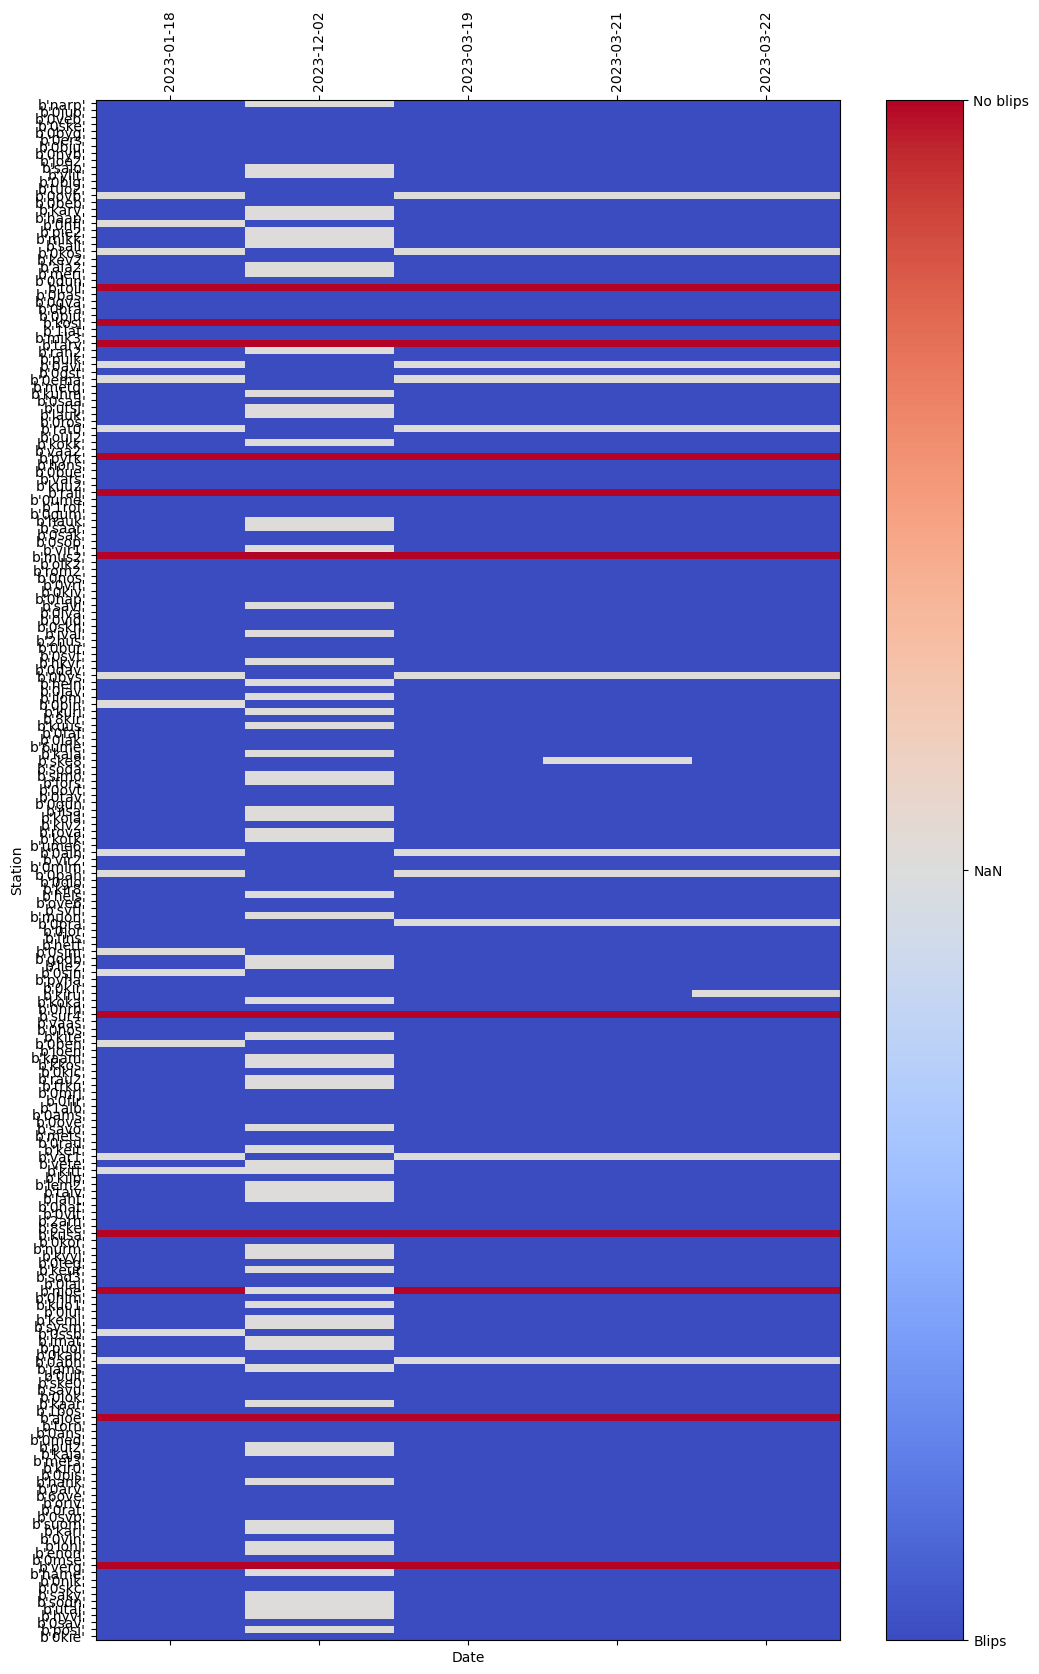

In [11]:
# Extract unique stations
all_stations = list(set(sum(sitedf['stations'].tolist() + sitedf['blip_stations'].tolist(), [])))

# Initialize a DataFrame to track station usage
station_usage = pd.DataFrame(index=sitedf['date'], columns=all_stations)

# Populate the DataFrame
for idx, row in sitedf.iterrows():
    for station in row['stations']:
        station_usage.at[row['date'], station] = 'Blips'
    for station in row['blip_stations']:
        station_usage.at[row['date'], station] = 'Noblips'


# Identify stations that are always used and never used
always_blips = station_usage.columns[(station_usage == 'Blips').all()].tolist()
never_blips = station_usage.columns[(station_usage == 'Noblips').all()].tolist()

print("Always blips:", always_blips)
print("Never blips:", never_blips)

# Filter out these stations
filtered_usage = station_usage#.drop(columns=always_blips + never_blips)

# Convert 'Used'/'Unused' to binary values for plotting
binary_usage = filtered_usage.applymap(lambda x: 1 if x == 'Noblips' else (-1 if x == 'Blips' else 0))

# Plot the heatmap
fig, ax = plt.subplots(figsize=(12, 20))

# Create the heatmap
cax = ax.matshow(binary_usage.T, cmap='coolwarm', aspect='auto')

# Set axis labels
ax.set_xticks(np.arange(len(filtered_usage.index)))
ax.set_xticklabels([date.strftime('%Y-%m-%d') for date in filtered_usage.index], rotation=90)
ax.set_yticks(np.arange(len(filtered_usage.columns)))
ax.set_yticklabels(filtered_usage.columns)

# Add colorbar
cbar = fig.colorbar(cax, ticks=[-1, 0, 1])
cbar.ax.set_yticklabels(['Blips', 'NaN', 'No blips'])

plt.xlabel('Date')
plt.ylabel('Station')
plt.show()

In [23]:
Always_blips = ["b'6ove'", "b'0bue'", "b'0kiv'", "b'kir8'", "b'0svt'", 
                        "b'vaas'", "b'0ove'", "b'0skh'", "b'0skc'", "b'6ume'", 
                        "b'0gum'", "b'0bra'", "b'torn'", "b'2arh'", "b'svtl'", 
                        "b'0kor'", "b'0med'", "b'2hus'", "b'0jav'", "b'pyha'", 
                        "b'0ers'", "b'joen'", "b'olk2'", "b'hett'", "b'pulk'", 
                        "b'0pis'", "b'0ovt'", "b'savu'", "b'1bos'", "b'0ans'", 
                        "b'0nat'", "b'0ske'", "b'rom2'", "b'0svp'", "b'0nos'", 
                        "b'0sak'", "b'1rof'", "b'0sav'", "b'0faf'", "b'0veb'", 
                        "b'mets'", "b'kuu2'", "b'0vin'", "b'kiv2'", "b'vir2'", 
                        "b'0juo'", "b'0kir'", "b'0tav'", "b'oriv'", "b'hons'", 
                        "b'0vri'", "b'tuo2'", "b'0gst'", "b'0flr'", "b'0laj'", 
                        "b'0lak'", "b'ove6'", "b'0gun'", "b'0lul'", "b'8kir'", 
                        "b'0hlm'", "b'kir0'", "b'0dun'", "b'ske0'", "b'0ams'", 
                        "b'0jor'", "b'kilp'", "b'oul2'", "b'vars'", "b'met3'", 
                        "b'0lva'", "b'fins'", "b'0gva'", "b'0kie'", "b'0ume'", 
                        "b'ume6'", "b'kev2'", "b'0bur'", "b'0mse'", "b'mik3'", 
                        "b'soda'", "b'0rat'", "b'0jok'", "b'0kic'", "b'0blg'", 
                        "b'0mrj'", "b'0bju'", "b'0beb'", "b'0arv'", "b'0glo'", 
                        "b'1alb'", "b'0bas'", "b'0vid'", "b'metg'", "b'0ull'", 
                        "b'0nik'", "b'joe2'", "b'0mlm'", "b'1lat'", "b'vaa2'", 
                        "b'0ros'", "b'0teg'", "b'0hos'", "b'sod3'", "b'0hap'", 
                        "b'0vit'", "b'0rau'", "b'0sop'", "b'0saa'", "b'8ske'", 
                        "b'0dav'", "b'0byg'", "b'0pju'", "b'0hrn'", "b'0kab'", "b'0nyb'"]


Never_blips = ["b'tarv'", "b'sur4'", "b'njoe'", "b'pyrk'", "b'ajoe'", 
                       "b'kusa'", "b'mus2'", "b'verg'", "b'rall'", "b'kosi'", "b'toil'"]

other = list(set(all_stations) - (set(Always_blips) | set(Never_blips)))

In [26]:
blips = pd.DataFrame({'gps_site': Always_blips, 'value': 1})
noblips = pd.DataFrame({'gps_site': Never_blips, 'value': -1})
others = pd.DataFrame({'gps_site': other, 'value': 0})

result_df = pd.concat([blips, noblips, others], ignore_index=True)
locs = raw.drop_duplicates(subset=['gps_site'])[['gps_site', 'gdlatr', 'gdlonr']]
dof = pd.merge(result_df, locs, on='gps_site', how='left')
dof

,gps_site,value,gdlatr,gdlonr
0,b'6ove',1,66.317825,22.773438
1,b'0bue',1,64.620918,21.204048
2,b'0kiv',1,67.794197,20.229149
3,b'kir8',1,67.877541,21.060179
4,b'0svt',1,64.512016,21.061623
...,...,...,...,...
213,b'saky',0,61.037754,22.403755
214,b'sodn',0,67.413567,26.591766
215,b'utaj',0,64.762154,26.414801
216,b'hyvi',0,60.630890,24.853443


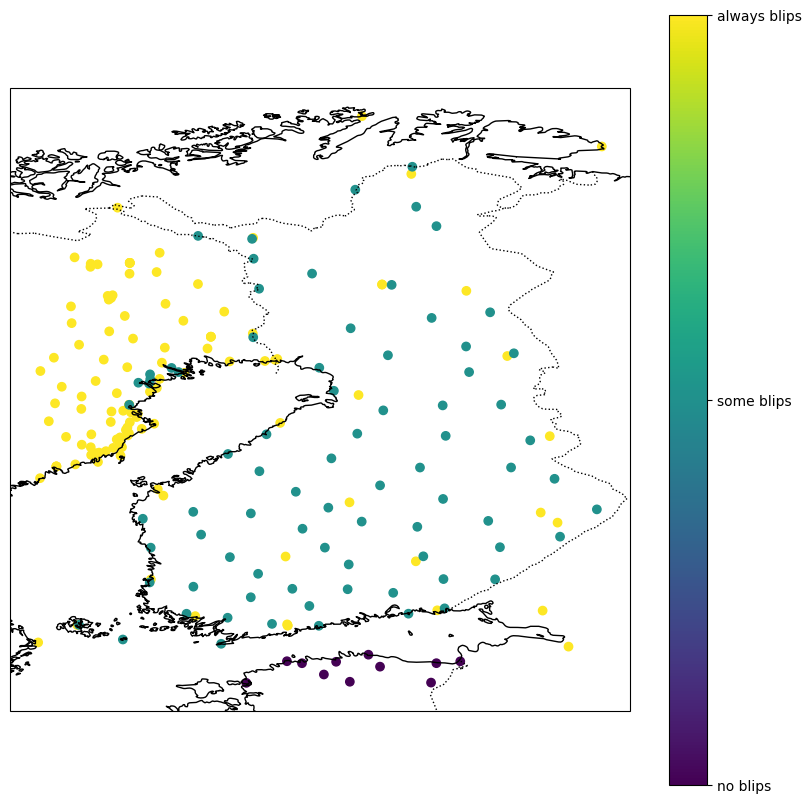

In [28]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')

plt.scatter(dof['gdlonr'], dof['gdlatr'],c= dof['value'])

cbar = plt.colorbar(ticks=[-1, 0, 1])
cbar.ax.set_yticklabels(['no blips', 'some blips', 'always blips'])
plt.show(fig)